# Kernel 3.2

the roi algorithm is working perfectly fine. well in this version we will keep it simple on roi. We will try to find roi just once,then use it for entire video analysis. in this vesion I will try to make the analysis in rgb only then increase later on

In [1]:
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

In [2]:
videos = glob.glob('./video_in/*.avi')
print(videos)

['./video_in/HeartRate_2.avi']


In [3]:
#just get the file name nothing less nothing more
filename_ext = os.path.basename(videos[0])
filename, file_extension  = os.path.splitext(filename_ext)
print(filename)

HeartRate_2


## Find Roi
get image frame and try to find roi if not just keep doing it until we find one
return format startPts and endPts each has a type of list

In [114]:
from PIL import Image, ImageDraw
import face_recognition

def find_roi(img_in):
    
    # here the part to develop the pipeline of the filer
    rgb_img = cv2.cvtColor(img_in, cv2.COLOR_BGR2RGB)
    face_landmarks_list = face_recognition.face_landmarks(rgb_img)
    people_num = len(face_landmarks_list)
    print("I found {} face(s) in this photograph.".format(people_num))
    if people_num == 0:
        return False, [], []

    # working with only the first face
    face_landmarks = face_landmarks_list[0]  

    
    chin_list = face_landmarks['chin']
    x1 = chin_list[0][0]
    y1 = chin_list[0][1]
    x2 = chin_list[len(chin_list)-1][0]
    y2 = chin_list[int((len(chin_list)-1)/2)][1]
    # img_out = roi_draw(rgb_img,x1,y1,x2,y2)
    y_dis = y2 - y1
    y0 = int(y1 - 0.6*y_dis)
#     dist_x = x2 - x1
#     dist_y = y2 - y0
    return True, [x1,y0], [x2,y2]


In [115]:
# here's the main working pipeline
# we going to read out the video frame by frame
# then using our face landmark detection to marking the frame and write it out another video

# get video handle
video = videos[0]
cap_in = cv2.VideoCapture(video)
try:
    # Find OpenCV version
    (major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
    if int(major_ver)  < 3 :
        fps = cap_in.get(cv2.cv.CV_CAP_PROP_FPS)
        total = int(cap_in.get(cv2.cv.CAP_PROP_FRAME_COUNT))
        print("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps))
    else :
        fps = cap_in.get(cv2.CAP_PROP_FPS)
        total = int(cap_in.get(cv2.CAP_PROP_FRAME_COUNT))
        print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))
except:
    cap_in.release()
    cv2.destroyAllWindows()
    
print("the total number of frames in this video is: {0}".format(total))

Frames per second using video.get(cv2.CAP_PROP_FPS) : 30.00003000003
the total number of frames in this video is: 654


In [116]:
try:
    while(True):
        ret, frame = cap_in.read()
        if not ret:
            print(ret)
            break
        roi_avai, pts_st, pts_end = find_roi(frame)
        if roi_avai:
            break
    cap_in.release()
    cv2.destroyAllWindows()
    print('done')
except:
    cap_in.release()
    cv2.destroyAllWindows()
    print('fail')

I found 1 face(s) in this photograph.
done


In [117]:
print(pts_st,pts_end)

[249, 92] [376, 267]


In [121]:
# mean = frame[pts_st[1]:pts_end[1],pts_st[0]:pts_end[0]]
a = np.mean(frame[pts_st[1]:pts_end[1],pts_st[0]:pts_end[0],1])
print(a)

143.45444319460069


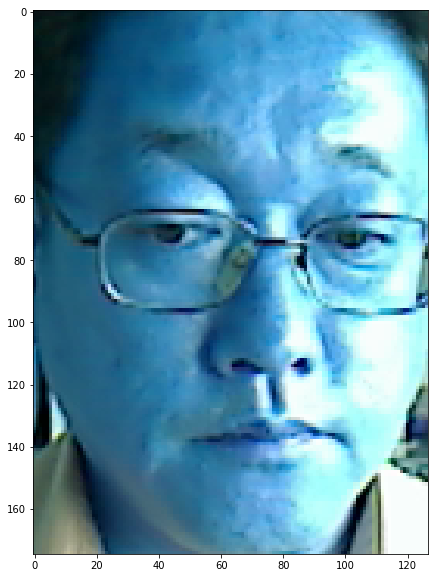

In [119]:
img_out = frame[pts_st[1]:pts_end[1],pts_st[0]:pts_end[0]]
plt.figure(figsize=(40,10))
plt.imshow(img_out)
plt.show()

In [8]:
#check if roi is correct
def roi_draw(img_in, pts_st, pts_end):
    roi_draw_img = np.array(img_in, copy=True)  
#     roi_draw_img = img_in
    cv2.rectangle(roi_draw_img,(pts_st[0],pts_st[1]),(pts_end[0],pts_end[1]),(0,0,255),2)
    return roi_draw_img

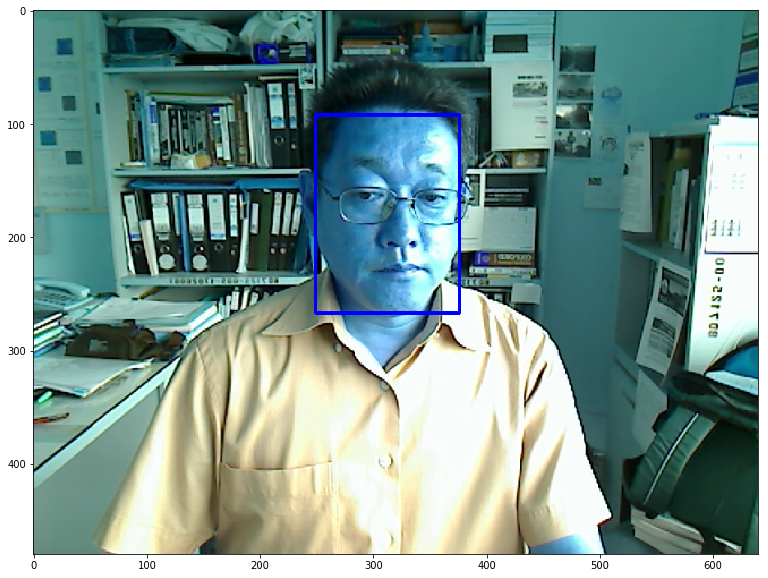

In [88]:
img_out = roi_draw(frame,pts_st,pts_end)
# img_out = rgb_img
plt.figure(figsize=(40,10))
plt.imshow(img_out)
plt.show()

## Grouping up

In [10]:
mask_x_size = 10
mask_y_size = 10

#cal roi box size
dist_x = pts_end[0] - pts_st[0]
dist_y = pts_end[1] - pts_st[1]
grp_x = int(dist_x/mask_x_size)
grp_y = int(dist_y/mask_y_size)
print(dist_x,dist_y)
print(grp_x,grp_y)

127 175
12 17


In [11]:
type(frame)
print(frame.shape)

(480, 640, 3)


In [12]:
# arr_mean = np.zeros((mask_x_size,mask_y_size,3),dtype=np.int64)

In [13]:
a = frame[pts_st[0]:pts_st[0]+10,pts_st[1]:pts_st[1]+10,0]
b = frame[pts_st[0]:pts_st[0]+10,pts_st[1]:pts_st[1]+10,1]
c = frame[pts_st[0]:pts_st[0]+10,pts_st[1]:pts_st[1]+10,2]
mean_a = np.mean(a)
mean_b = np.mean(b)
mean_c = np.mean(c)

print(mean_a)
print(mean_b)
print(mean_c)

112.36
143.3
116.82


In [14]:
section = frame[pts_st[0]:pts_st[0]+10,pts_st[1]:pts_st[1]+10]
print(section.shape)

(10, 10, 3)


In [15]:
mean_sec = np.mean(section,axis=(0,1))
print(mean_sec)

[112.36 143.3  116.82]


In [16]:
cap_in.release()
cv2.destroyAllWindows()

In [49]:
indX_st = pts_st[0]
indY_st = pts_st[1]
for i in range(0,grp_y-1):
    indY_end = indY_st + mask_y_size
    for j in range(0,grp_x-1):
        indX_end = indX_st + mask_x_size
        print(indX_st,indX_end,indY_st,indY_end)
        indX_st = indX_end + 1
    indX_st = pts_st[0]
    indY_st = indY_end + 1

249 259 92 102
260 270 92 102
271 281 92 102
282 292 92 102
293 303 92 102
304 314 92 102
315 325 92 102
326 336 92 102
337 347 92 102
348 358 92 102
359 369 92 102
249 259 103 113
260 270 103 113
271 281 103 113
282 292 103 113
293 303 103 113
304 314 103 113
315 325 103 113
326 336 103 113
337 347 103 113
348 358 103 113
359 369 103 113
249 259 114 124
260 270 114 124
271 281 114 124
282 292 114 124
293 303 114 124
304 314 114 124
315 325 114 124
326 336 114 124
337 347 114 124
348 358 114 124
359 369 114 124
249 259 125 135
260 270 125 135
271 281 125 135
282 292 125 135
293 303 125 135
304 314 125 135
315 325 125 135
326 336 125 135
337 347 125 135
348 358 125 135
359 369 125 135
249 259 136 146
260 270 136 146
271 281 136 146
282 292 136 146
293 303 136 146
304 314 136 146
315 325 136 146
326 336 136 146
337 347 136 146
348 358 136 146
359 369 136 146
249 259 147 157
260 270 147 157
271 281 147 157
282 292 147 157
293 303 147 157
304 314 147 157
315 325 147 157
326 336 147 157
337

In [84]:
# img_sh = frame[249:259,92:102]
print(frame)
# # img_out = rgb_img
# plt.figure(figsize=(40,10))
# plt.imshow(img_out)
# plt.show()

None


## Running mean calculation on the whole video

In [131]:
cap_in.release()
cv2.destroyAllWindows()

In [132]:
# here's the main working pipeline
# we going to read out the video frame by frame
# then using our face landmark detection to marking the frame and write it out another video

# get video handle
video = videos[0]
cap_in = cv2.VideoCapture(video)
try:
    # Find OpenCV version
    (major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
    if int(major_ver)  < 3 :
        fps = cap_in.get(cv2.cv.CV_CAP_PROP_FPS)
        total = int(cap_in.get(cv2.cv.CAP_PROP_FRAME_COUNT))
        print("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps))
    else :
        fps = cap_in.get(cv2.CAP_PROP_FPS)
        total = int(cap_in.get(cv2.CAP_PROP_FRAME_COUNT))
        print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))
except:
    cap_in.release()
    cv2.destroyAllWindows()
    
print("the total number of frames in this video is: {0}".format(total))

Frames per second using video.get(cv2.CAP_PROP_FPS) : 30.00003000003
the total number of frames in this video is: 654


In [133]:
# arr_mean = np.zeros((grp_x,grp_y,3,total),dtype=np.float64)
# print(arr_mean.shape)

In [134]:
def cal_mean(frame,mean_arr,frame_index):
    indX_st = pts_st[0]
    indY_st = pts_st[1]
    for i in range(0,grp_y-1):
        indY_end = indY_st + mask_y_size
        for j in range(0,grp_x-1):
            indX_end = indX_st + mask_x_size
#             print(indX_st,indX_end,indY_st,indY_end)
            section = frame[indY_st:indY_end,indX_st:indX_end]
            mean_sec = np.mean(section,axis=(0,1))
#             print(i,j,frame_index)
            mean_arr[j,i,0,frame_index] = mean_sec[0]
            mean_arr[j,i,1,frame_index] = mean_sec[1]
            mean_arr[j,i,2,frame_index] = mean_sec[2]
            indX_st = indX_end + 1
        indX_st = pts_st[0]
        indY_st = indY_end + 1
    mean_arr[grp_x-1,grp_y-1,0,frame_index] = np.mean(frame[pts_st[1]:pts_end[1],pts_st[0]:pts_end[0],0])
    mean_arr[grp_x-1,grp_y-1,1,frame_index] = np.mean(frame[pts_st[1]:pts_end[1],pts_st[0]:pts_end[0],1])
    mean_arr[grp_x-1,grp_y-1,2,frame_index] = np.mean(frame[pts_st[1]:pts_end[1],pts_st[0]:pts_end[0],2])
    frame_sh = frame[indX_st:indX_end,indY_st:indY_end]
    # img_out = rgb_img
#     plt.figure(figsize=(40,10))
#     plt.imshow(frame_sh)
#     plt.show()

In [135]:
frame_index = 0
arr_mean = np.zeros((grp_x,grp_y,3,total),dtype=np.float64)

while(True):
    ret, frame = cap_in.read()
    if not ret:
        print(ret)
        break
#         roi_avai, pts_st, pts_end = find_roi(frame)
    print(frame_index)
    cal_mean(frame,arr_mean,frame_index)
    frame_index = frame_index +1
cap_in.release()
cv2.destroyAllWindows()
print('done')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [136]:
print(indX_st,indX_end,indY_st,indY_end)
print( pts_st[0])

0 0 0 0
249


In [140]:
print(arr_mean[-2,-2,1,0:-1])

[219.74 220.63 221.06 221.76 222.31 223.16 223.47 222.97 222.58 221.97
 221.25 221.01 220.75 220.3  219.71 219.58 219.36 218.3  217.14 215.51
 214.25 213.25 212.11 210.48 209.28 207.82 206.6  206.42 205.97 205.1
 204.35 203.47 203.16 202.85 202.98 202.98 202.92 202.75 202.82 203.
 203.08 203.08 203.67 204.08 205.17 206.1  206.51 207.32 208.75 210.58
 213.22 214.57 216.74 218.42 219.44 219.82 220.03 220.52 220.94 221.27
 221.68 222.1  221.49 221.7  221.78 221.77 221.99 222.35 222.4  222.95
 223.12 223.21 224.18 224.37 224.49 225.12 225.56 226.61 226.92 227.66
 228.46 228.73 229.21 229.89 229.9  230.49 230.76 230.92 231.   230.42
 230.28 229.65 228.33 227.95 226.71 225.17 224.08 222.46 221.89 221.83
 221.79 221.69 221.87 221.64 221.19 220.89 220.36 220.46 220.37 220.08
 219.57 219.66 219.7  219.78 220.13 220.22 220.26 220.35 220.63 221.41
 221.9  222.16 221.93 223.44 225.35 227.12 228.67 230.33 231.67 232.81
 233.92 234.52 235.09 235.46 235.82 236.15 236.59 236.75 237.25 237.44
 237.72 2

/home/deemarc/.local/lib/python3.5/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


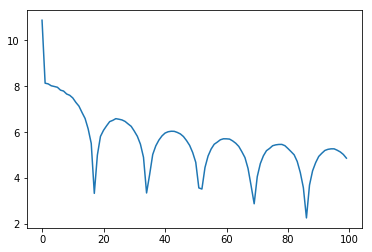

In [138]:
import scipy.fftpack


# Number of samplepoints
N = total-1

# sample spacing
T = 1.0 / 30
xf =np.arange(N)
yf = np.log(scipy.fftpack.fft(arr_mean[grp_x-1,grp_y-1,0,0:total-1]))
fig, ax = plt.subplots()
ax.plot(xf[0:100], yf[0:100])
plt.show()

/home/deemarc/.local/lib/python3.5/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


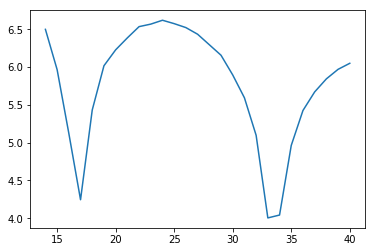

In [139]:
xf =np.arange(N)
yf = np.log(scipy.fftpack.fft(arr_mean[grp_x-1,grp_y-1,0,0:total]))
fig, ax = plt.subplots()
ax.plot(xf[14:41], yf[14:41])
plt.show()

In [28]:
# indX_st = pts_st[0]
# indY_st = pts_st[1]
# for i in range(0,grp_y-1):
#     indY_end = indY_st + mask_y_size
#     for j in range(0,grp_x-1):
#         print(i,j)

In [93]:
print(frame_index)

615
